In [48]:
using DIVAnd
using DelimitedFiles
using PyPlot
using Interpolations
using Statistics

In [2]:
datafile = "data_SA02_CTD201506_v2.dat"

"data_SA02_CTD201506_v2.dat"

## Read and plot data 

In [4]:
data = readdlm(datafile, skipstart=1);
lon = data[:,1]
lat = data[:,2] 
dist = data[:,3]
pres = data[:,4] 
S = data[:,5] 
oxy = data[:,6];

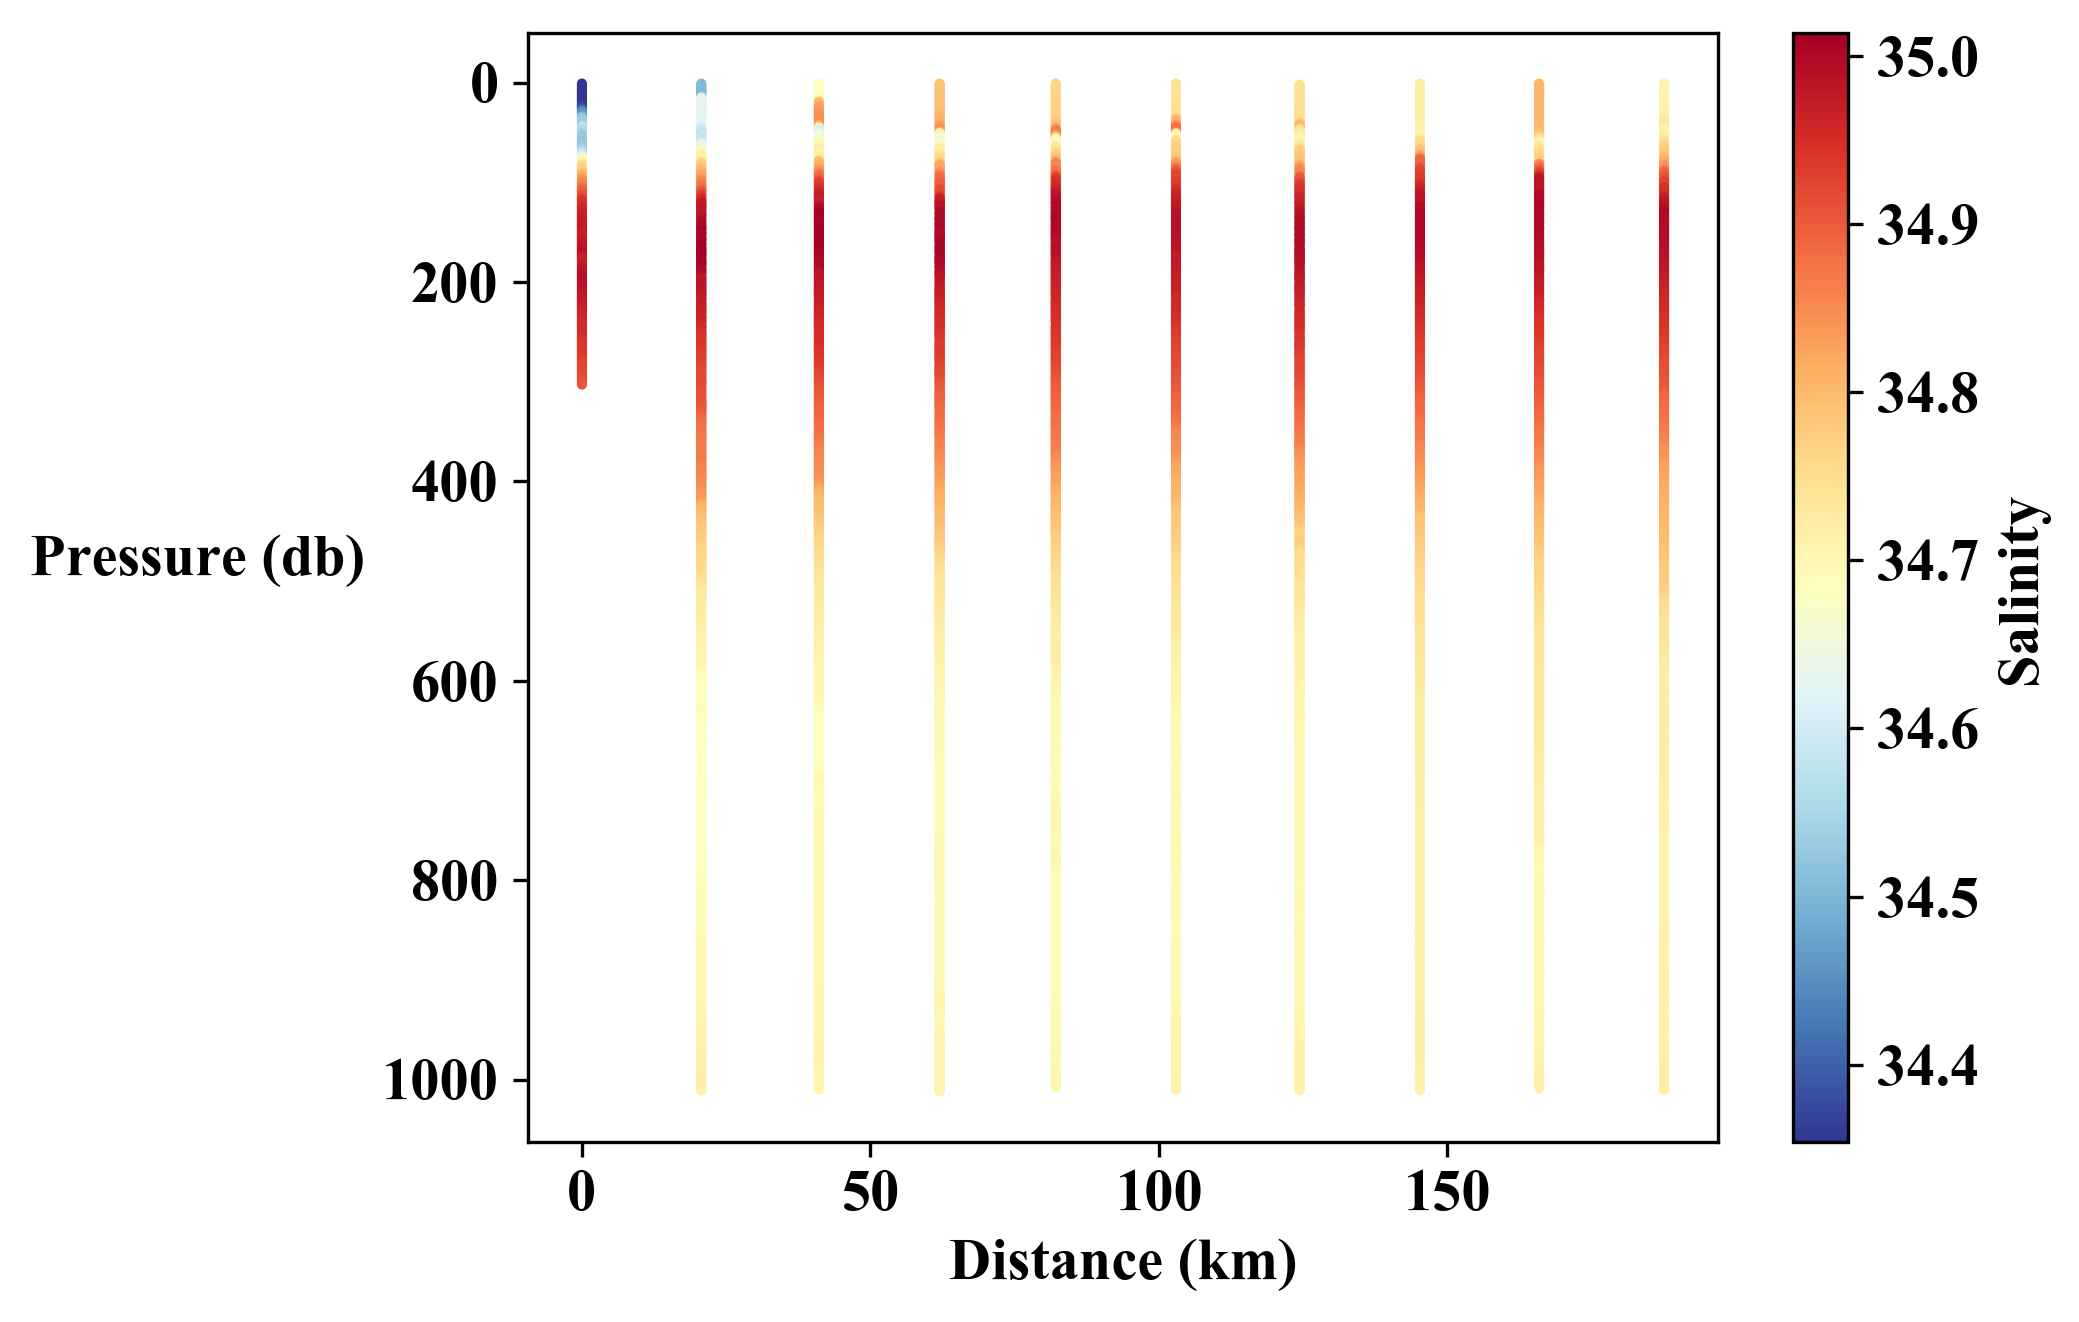

In [5]:
scat = PyPlot.scatter(dist, pres, s=2, c=S, cmap=PyPlot.cm.RdYlBu_r)
cb = PyPlot.colorbar(scat)
cb.set_label("Salinity")
xlabel("Distance (km)")
ylabel("Pressure (db)", rotation=0, ha="right")
PyPlot.gca().invert_yaxis()

## Extract and plot bathymetry

In [6]:
bathname = "../data/gebco_30sec_4.nc"
if !isfile(bathname)
    @info("Download bathymetry")
    download("https://dox.ulg.ac.be/index.php/s/RSwm4HPHImdZoQP/download",bathname)
else
    @info("Bathymetry file already downloaded")
end

┌ Info: Bathymetry file already downloaded
└ @ Main In[6]:6


We create a 2D grid for the bathymetry extraction.

In [7]:
lonmin, lonmax, latmin, latmax = minimum(lon), maximum(lon), minimum(lat), maximum(lat)
Δlon = lonmax - lonmin;
Δlat = latmax - latmin;
xi = lonmin - 0.05 * Δlon :0.01: lonmax + 0.05 * Δlon
yi = latmin - 0.05 * Δlat :0.01: latmax + 0.05 * Δlat

19.1423035:0.01:20.0323035

In [8]:
bx, by, b = DIVAnd.extract_bath(bathname, true, xi, yi)

(-107.31666666667078:0.03333333333333144:-105.55000000000422, 19.116666666706962:0.03333333333334565:20.05000000004064, [2844.8125 2989.5 … 3272.4375 3250.8125; 2942.4375 3040.875 … 3299.5625 3273.8125; … ; 4938.3125 4893.1875 … 84.5 59.5; 4948.3125 4865.125 … 41.1875 24.8125])

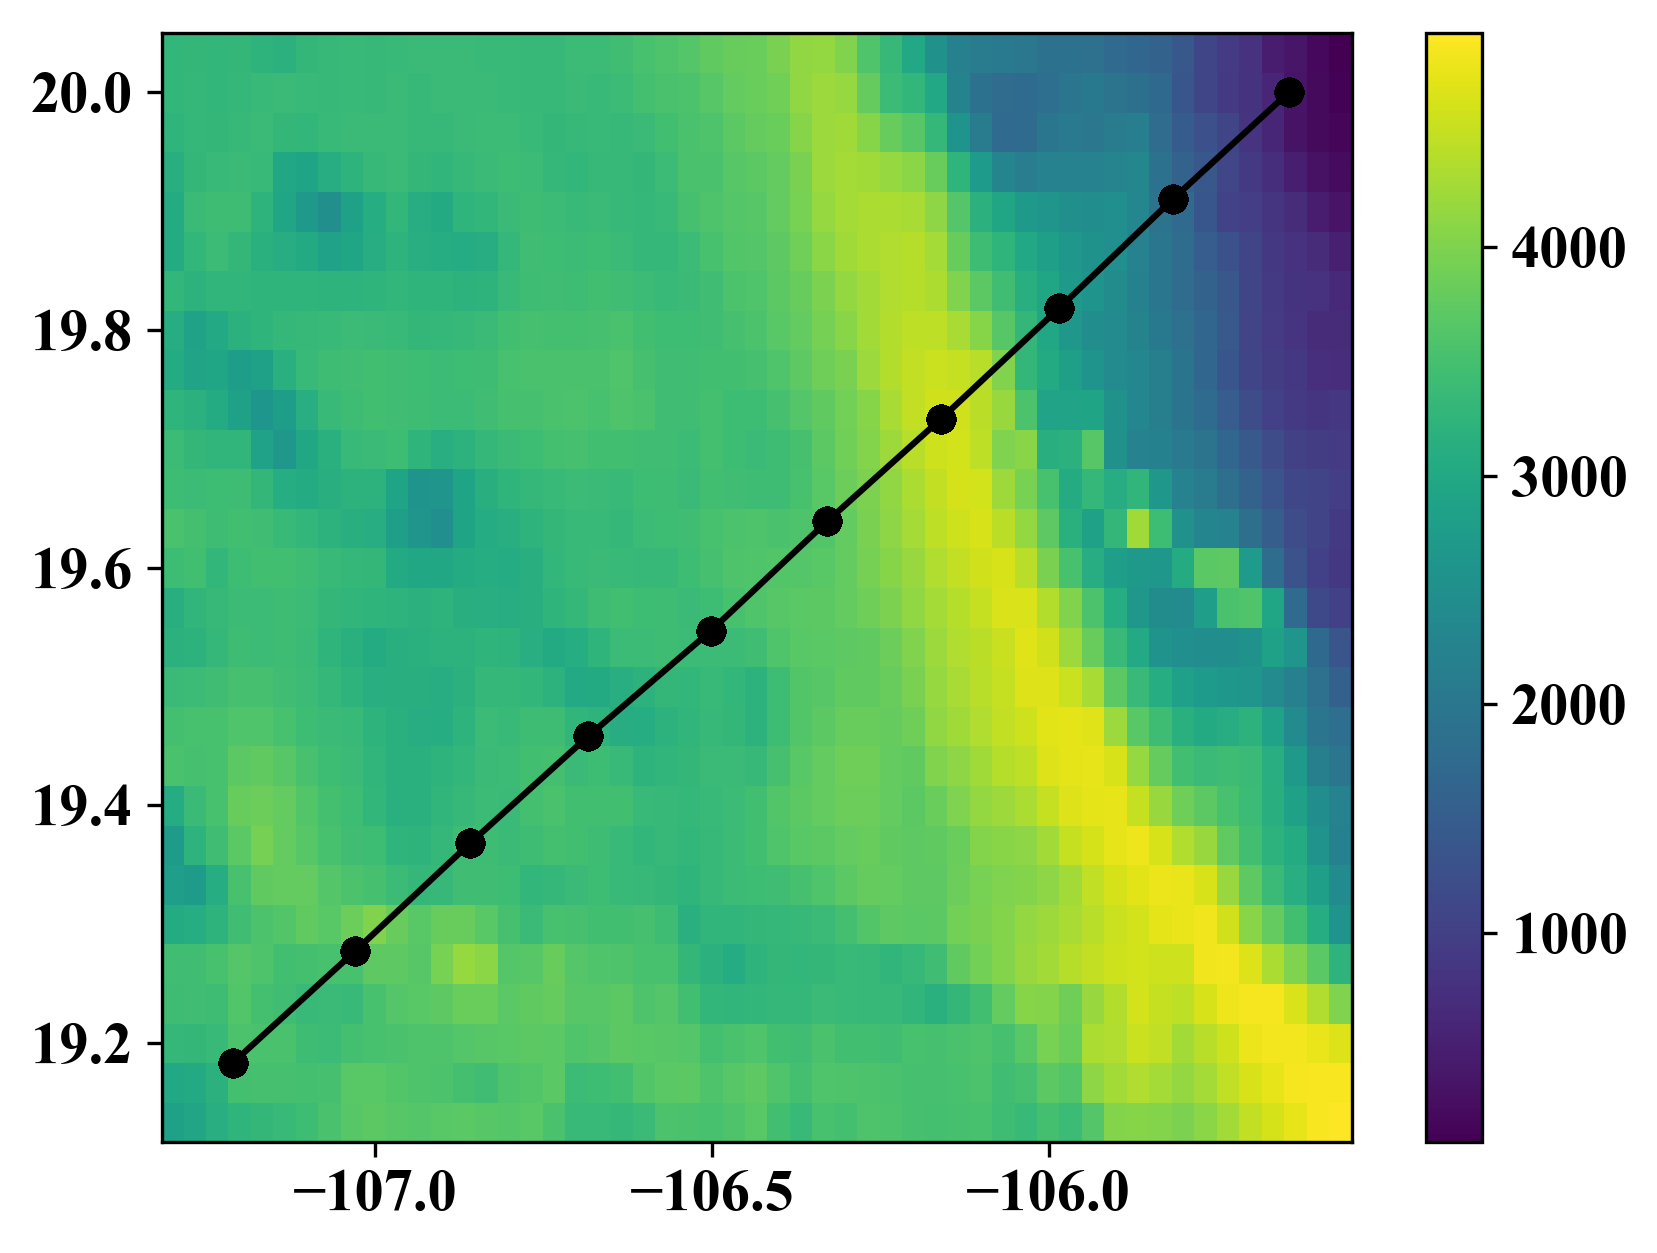

PyObject <matplotlib.colorbar.Colorbar object at 0x7f528f63ebd0>

In [9]:
pcm = PyPlot.pcolormesh(bx, by, b')
PyPlot.plot(lon, lat, "ko-")
PyPlot.colorbar(pcm)

### Create the interpolator

In [10]:
lon_u, lat_u = unique(lon), unique(lat)
itp = Interpolations.interpolate((bx, by), b, Gridded(Linear()));
depth_interp = itp.(lon_u, lat_u);

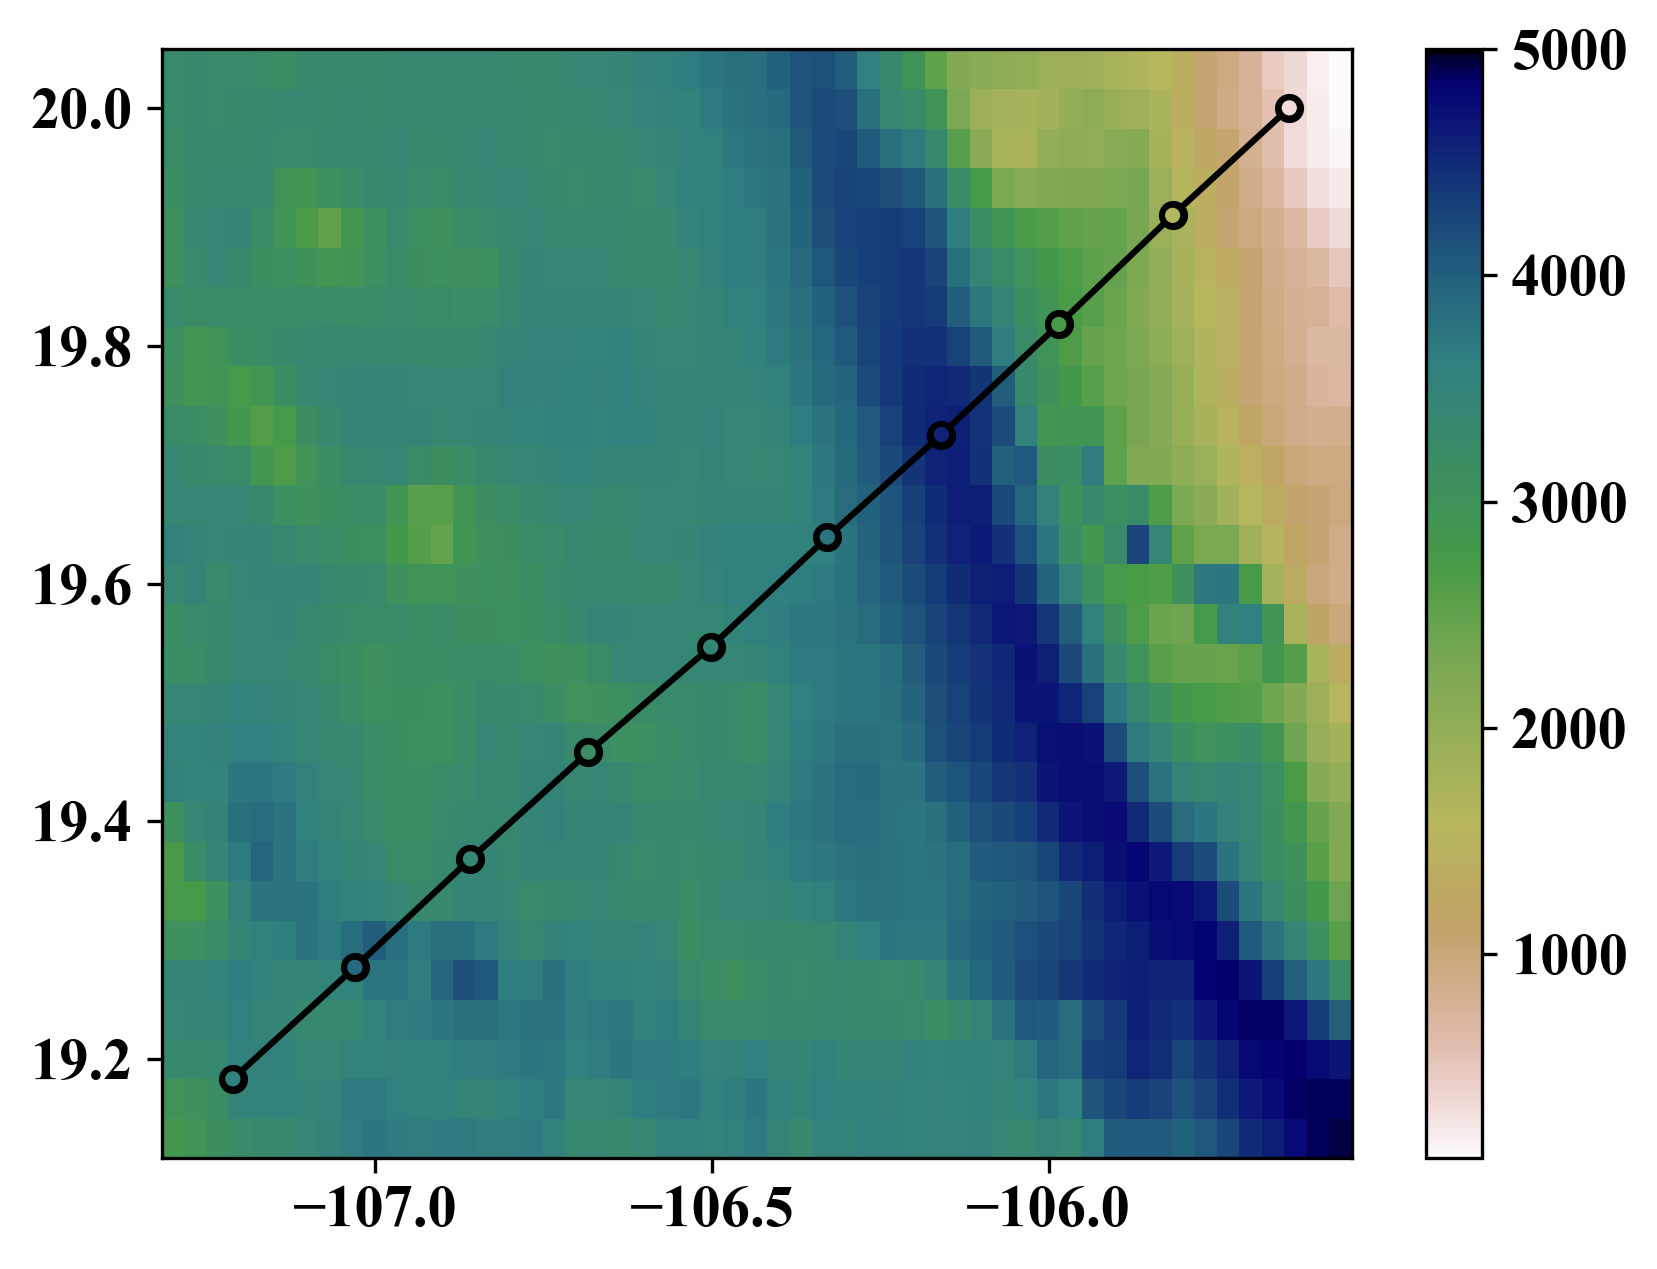

PyObject <matplotlib.colorbar.Colorbar object at 0x7f528f563510>

In [11]:
pcm = PyPlot.pcolormesh(bx, by, b', vmin=100., vmax=5000., cmap=PyPlot.cm.gist_earth_r)
PyPlot.plot(lon_u, lat_u, "ko-", zorder=3)
PyPlot.scatter(lon_u, lat_u, s=7, c=depth_interp, vmin=100., vmax=5000., 
    cmap=PyPlot.cm.gist_earth_r, zorder=4)
PyPlot.colorbar(pcm)

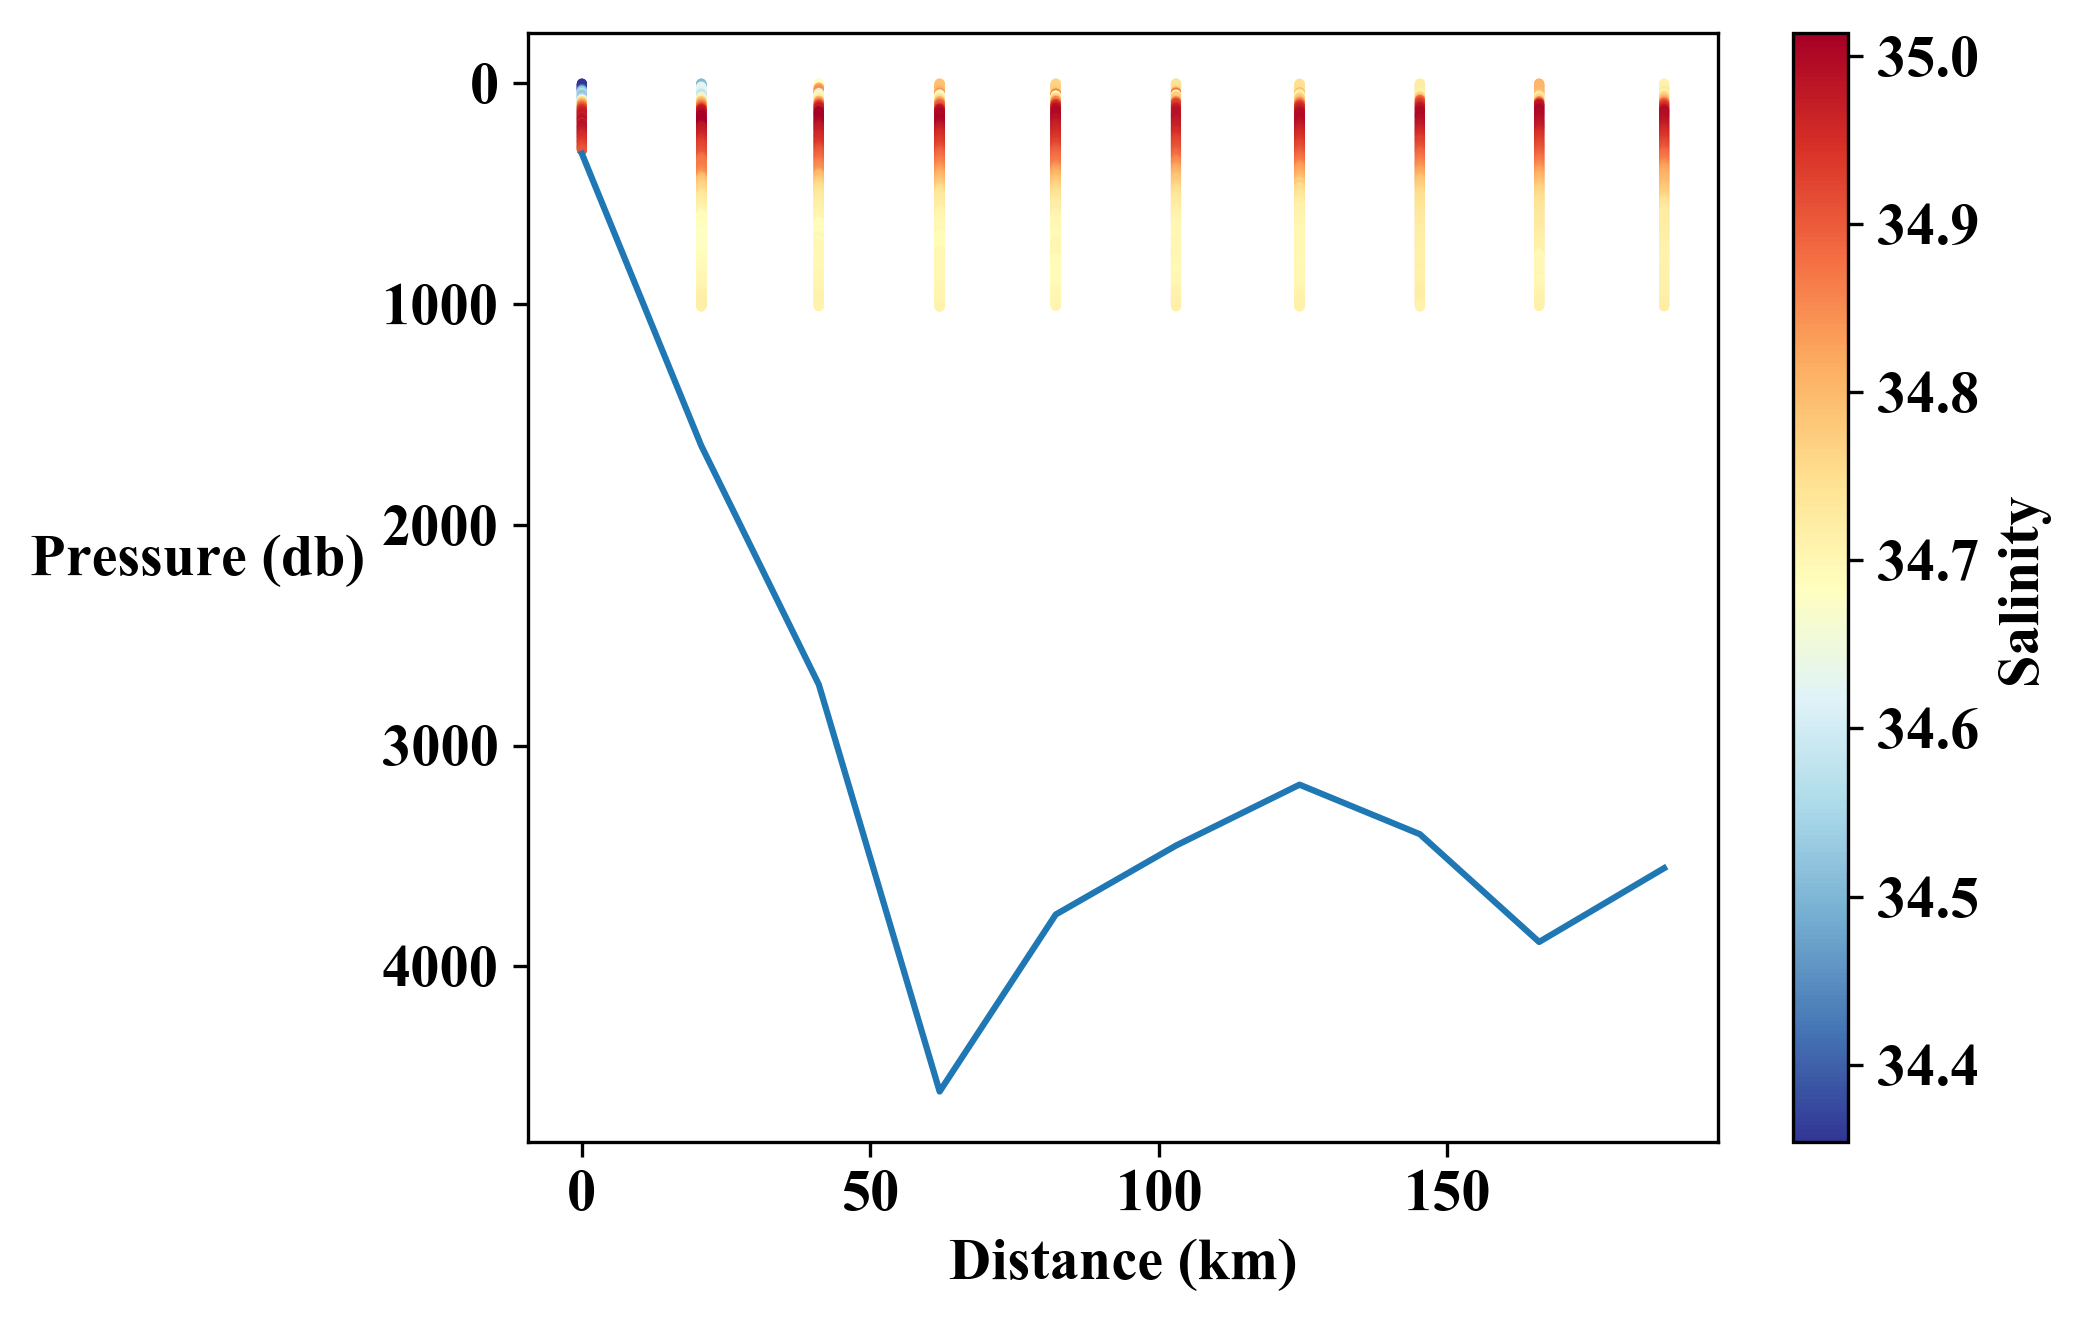

In [12]:
scat = PyPlot.scatter(dist, pres, s=2, c=S, cmap=PyPlot.cm.RdYlBu_r)
cb = PyPlot.colorbar(scat)
cb.set_label("Salinity")
PyPlot.plot(unique(dist), depth_interp)
xlabel("Distance (km)")
ylabel("Pressure (db)", rotation=0, ha="right")
PyPlot.gca().invert_yaxis()

## Create interpolation grid

In [21]:
Δd = 1. # km
Δh = 1. # meter
distgrid = collect(0.0:Δd:ceil(maximum(dist)))
depthgrid = collect(0.0:Δh:ceil(maximum(pres)));

### Land sea mask
First we interpolate the bathymetry on the distance grid.

In [22]:
npoints = length(distgrid)
lon_grid = range(lon[1], lon[end]; length=npoints);
lat_grid = range(lat[1], lat[end]; length=npoints)
depth_interp_grid = itp.(lon_grid, lat_grid);

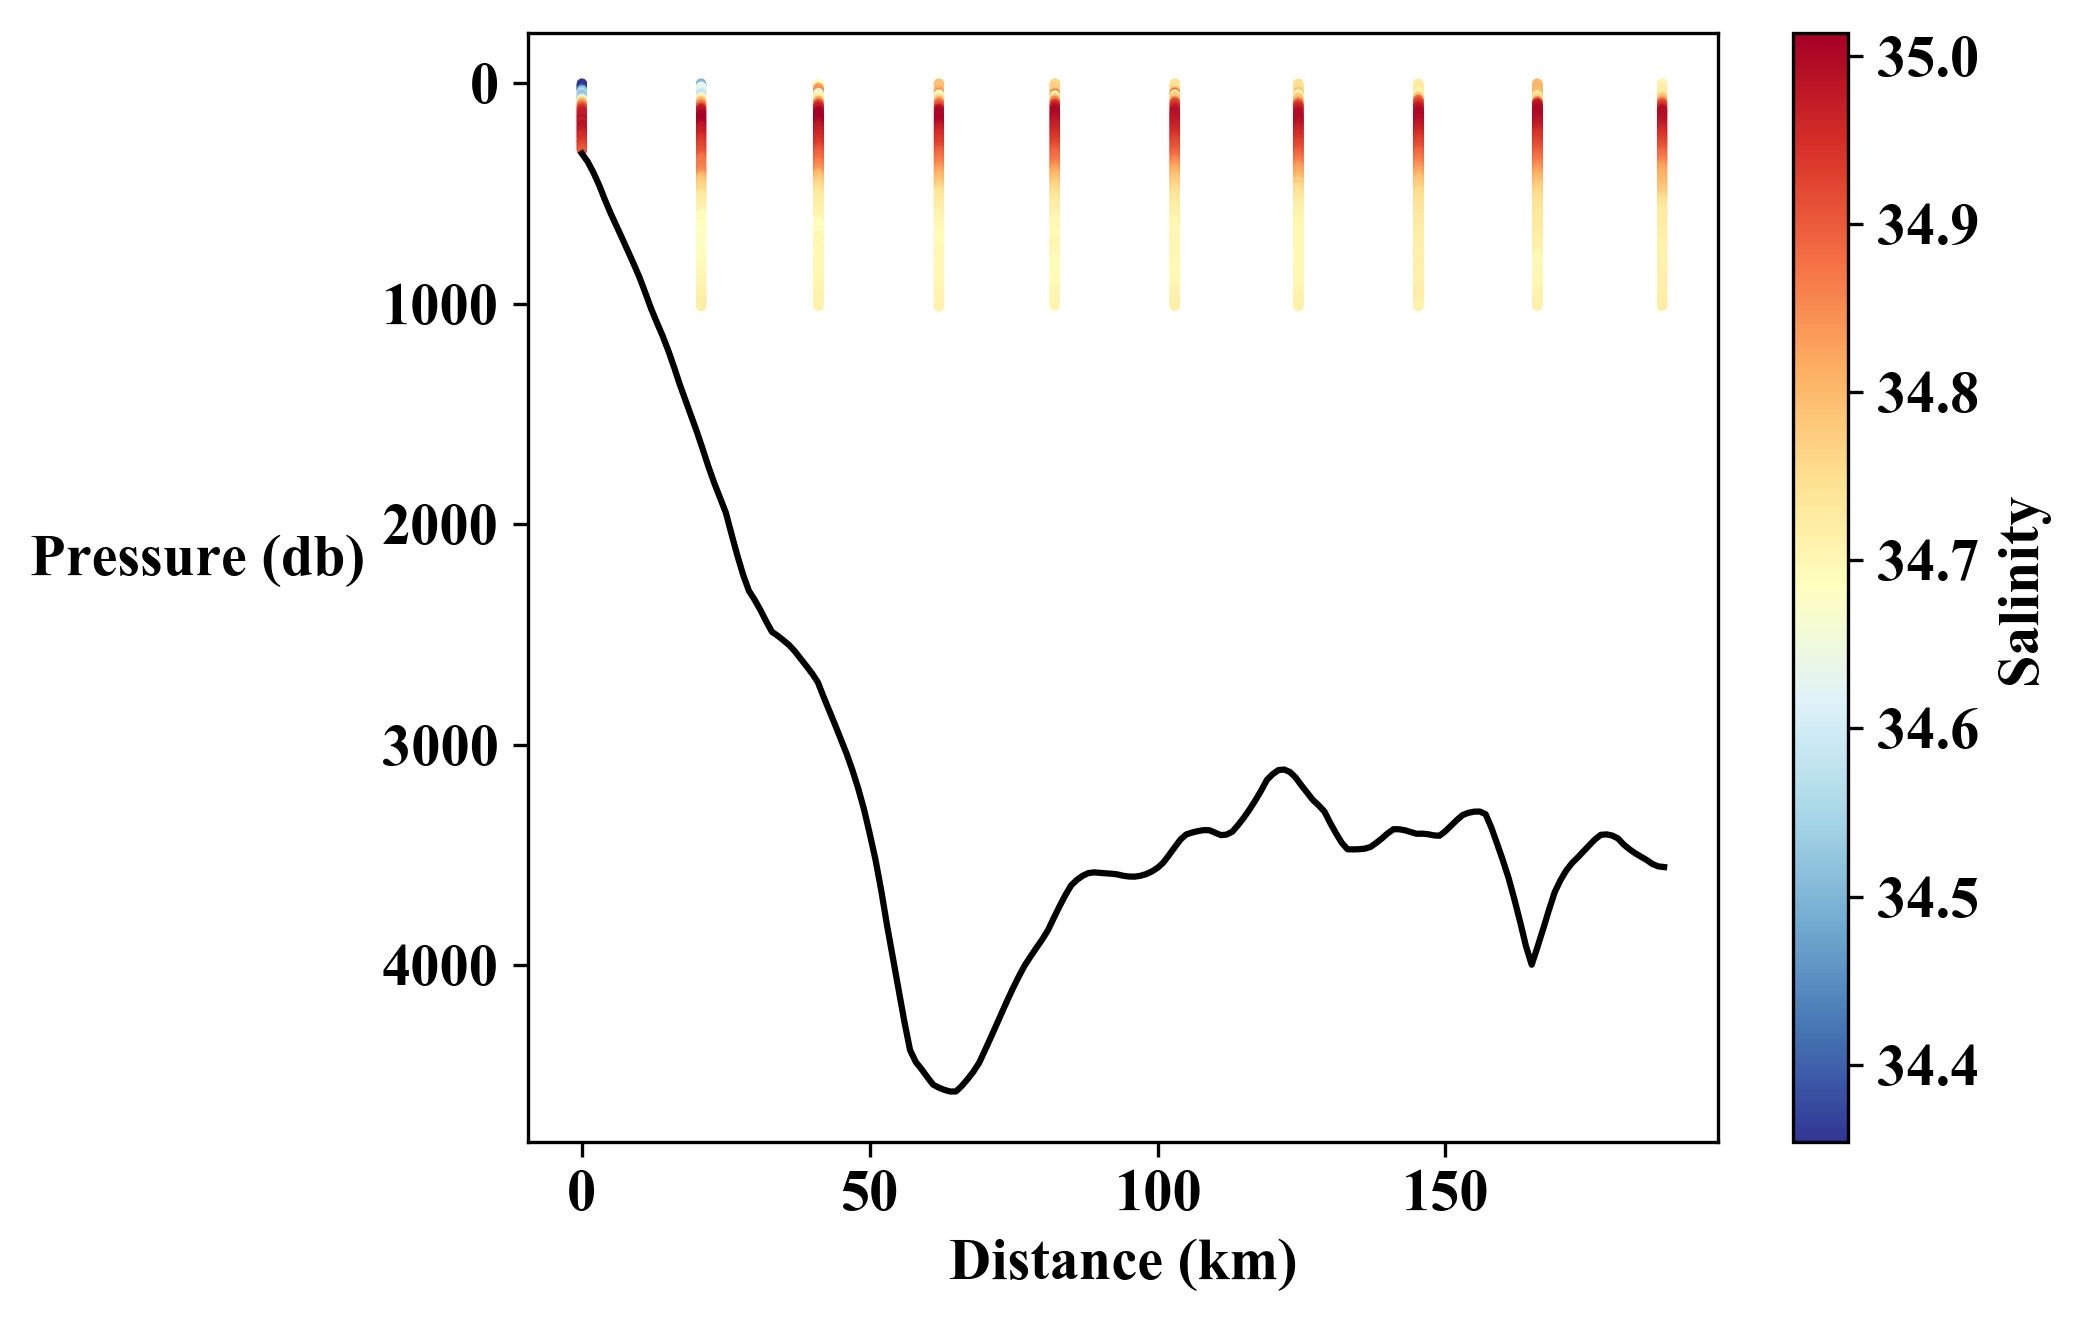

In [23]:
scat = PyPlot.scatter(dist, pres, s=2, c=S, cmap=PyPlot.cm.RdYlBu_r)
cb = PyPlot.colorbar(scat)
cb.set_label("Salinity")
PyPlot.plot(distgrid, depth_interp_grid, "k")
xlabel("Distance (km)")
ylabel("Pressure (db)", rotation=0, ha="right")
PyPlot.gca().invert_yaxis()

Then we can construct the mask.

In [26]:
mask = falses(length(distgrid), length(depthgrid));
for (ii, d) in enumerate(distgrid)
    for (jj, h) in enumerate(depthgrid)
        if h < depth_interp_grid[ii]
            mask[ii, jj] = true
        end
    end
end;

## Analysis
### Create metrics

In [33]:
mask_rect, pmn, xyi = DIVAnd_rectdom(distgrid, depthgrid);
xyi

([0.0 0.0 … 0.0 0.0; 1.0 1.0 … 1.0 1.0; … ; 187.0 187.0 … 187.0 187.0; 188.0 188.0 … 188.0 188.0], [0.0 1.0 … 1011.0 1012.0; 0.0 1.0 … 1011.0 1012.0; … ; 0.0 1.0 … 1011.0 1012.0; 0.0 1.0 … 1011.0 1012.0])

### Set parameters

In [59]:
len = (15.0 .* ones(length(distgrid), length(depthgrid)), 
        5.0 .* ones(length(distgrid), length(depthgrid))) # km, meters
epsilon2 = 5.

5.0

### Run analysis
We remove the mean value to get the anomalies.
#### Salinity

In [60]:
Sinterp, S_struct = DIVAndrun(mask_rect, pmn, xyi, (dist, pres), S .- mean(S), 
    len, epsilon2, alphabc=0);

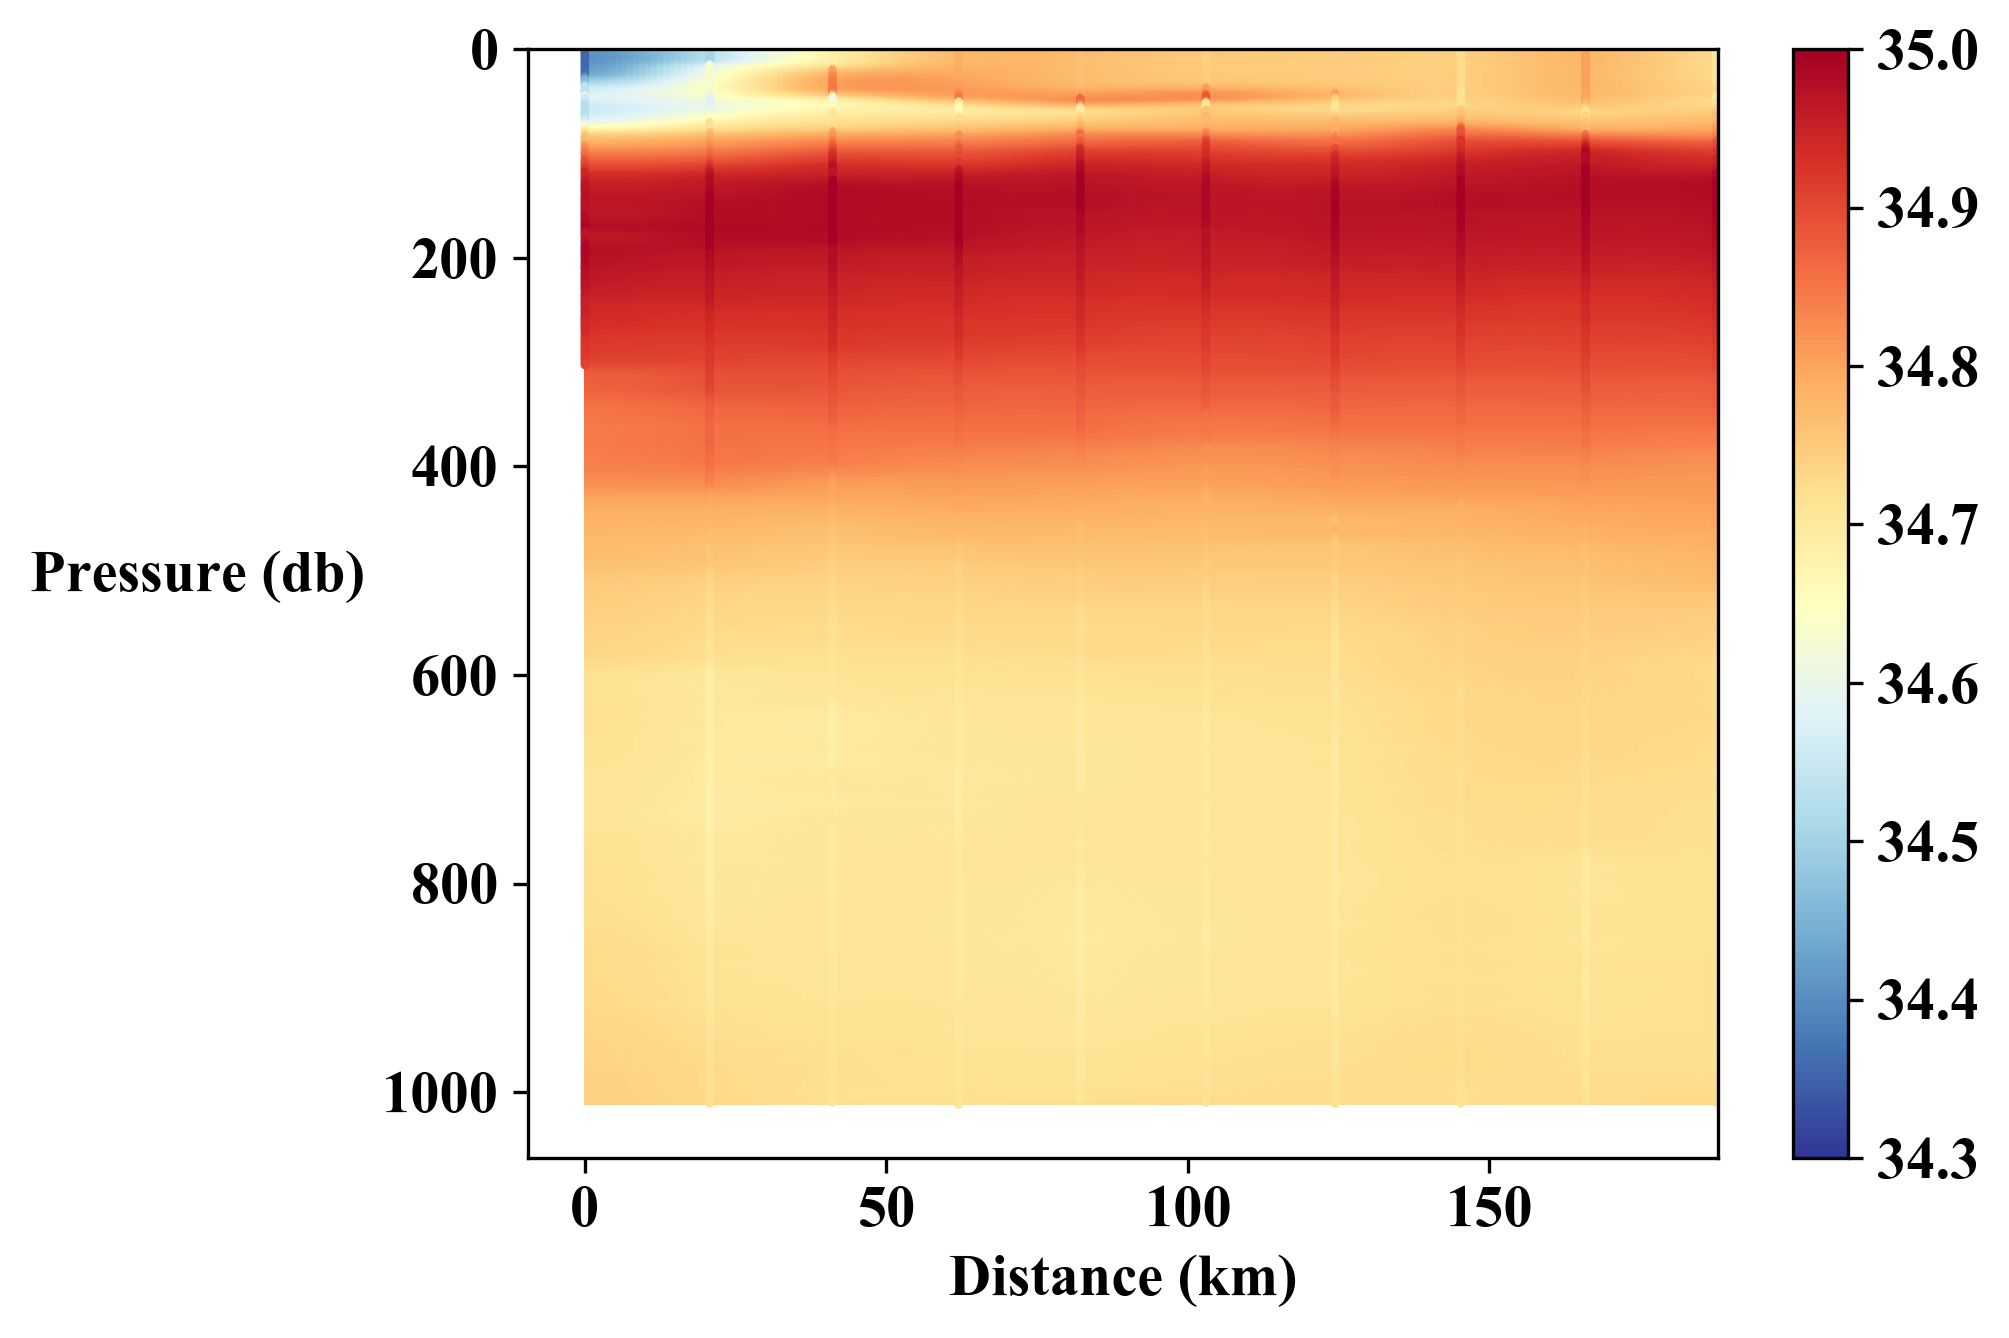

In [61]:
Smin, Smax = 34.3, 35.
PyPlot.pcolormesh(distgrid, depthgrid, Sinterp' .+ mean(S), 
    vmin=Smin, vmax=Smax, cmap=PyPlot.cm.RdYlBu_r)
PyPlot.scatter(dist, pres, s=1, c=S, 
    vmin=Smin, vmax=Smax, cmap=PyPlot.cm.RdYlBu_r)
xlabel("Distance (km)")
ylabel("Pressure (db)", rotation=0, ha="right")
PyPlot.colorbar()
PyPlot.gca().invert_yaxis()

#### Oxygen

In [52]:
Oxyinterp, Oxy_struct = DIVAndrun(mask_rect, pmn, xyi, (dist, pres), oxy .- mean(oxy), 
    len, epsilon2, alphabc=0);

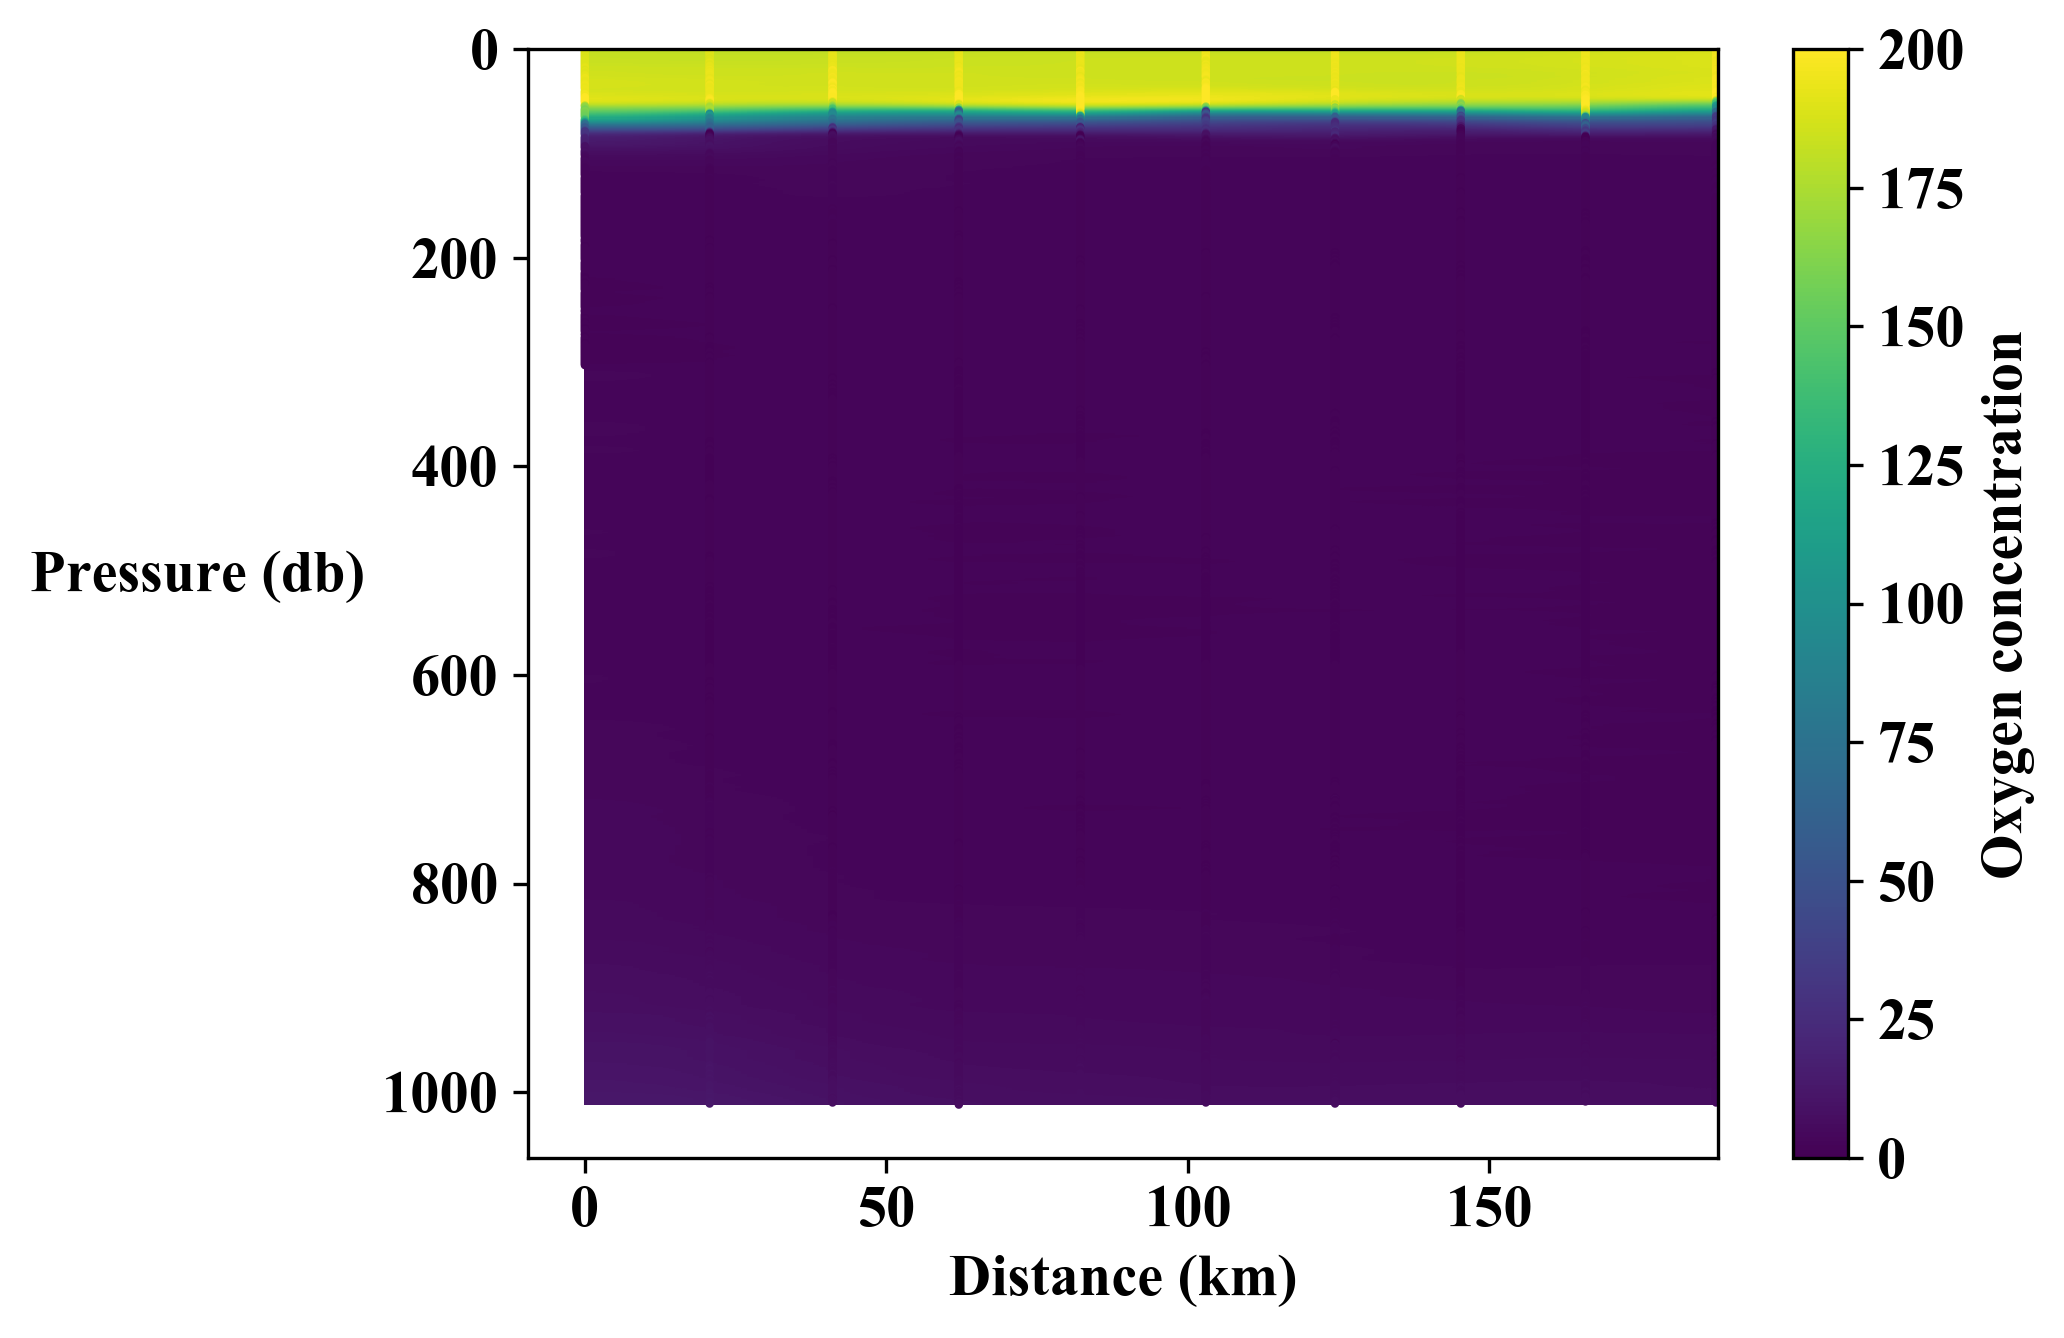

In [62]:
oxymin, oxymax = 0., 200.
pcm = PyPlot.pcolormesh(distgrid, depthgrid, Oxyinterp' .+ mean(oxy), 
    vmin=oxymin, vmax=oxymax)
PyPlot.scatter(dist, pres, s=1, c=oxy, 
    vmin=oxymin, vmax=oxymax)
cb = PyPlot.colorbar(pcm)
cb.set_label("Oxygen concentration")
xlabel("Distance (km)")
ylabel("Pressure (db)", rotation=0, ha="right")
PyPlot.gca().invert_yaxis()